In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir /root/.kaggle/
!cp /content/drive/MyDrive/Colab\ Notebooks/Kaggle/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gpiosenka/100-bird-species
!unzip 100-bird-species.zip
!rm -r ./dataset
!mkdir ./dataset
!mv ./test ./dataset/test
!mv ./train ./dataset/train
!mv ./valid ./dataset/valid

Streaming output truncated to the last 5000 lines.
  inflating: train/WHITE TAILED TROPIC/121.jpg  
  inflating: train/WHITE TAILED TROPIC/122.jpg  
  inflating: train/WHITE TAILED TROPIC/123.jpg  
  inflating: train/WHITE TAILED TROPIC/124.jpg  
  inflating: train/WHITE TAILED TROPIC/125.jpg  
  inflating: train/WHITE TAILED TROPIC/126.jpg  
  inflating: train/WHITE TAILED TROPIC/127.jpg  
  inflating: train/WHITE TAILED TROPIC/128.jpg  
  inflating: train/WHITE TAILED TROPIC/129.jpg  
  inflating: train/WHITE TAILED TROPIC/130.jpg  
  inflating: train/WHITE TAILED TROPIC/131.jpg  
  inflating: train/WHITE TAILED TROPIC/132.jpg  
  inflating: train/WHITE TAILED TROPIC/133.jpg  
  inflating: train/WHITE TAILED TROPIC/134.jpg  
  inflating: train/WHITE TAILED TROPIC/135.jpg  
  inflating: train/WHITE TAILED TROPIC/136.jpg  
  inflating: train/WHITE TAILED TROPIC/137.jpg  
  inflating: train/WHITE TAILED TROPIC/138.jpg  
  inflating: train/WHITE TAILED TROPIC/139.jpg  
  inflating: train

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Rescaling, Dropout, BatchNormalization
from keras.models import Sequential
from keras import layers
import os
import time
import numpy as np

In [4]:
train_dir = os.path.join('.','dataset','train')
test_dir = os.path.join('.','dataset','test')
val_dir = os.path.join('.','dataset','valid')
random_seed = 123
batch_size = 16
IMG_SIZE = (224,224)

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    seed = random_seed,
    shuffle = True,
    validation_split = 0.2,
    subset = 'training',
    batch_size = batch_size,
    image_size = IMG_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    seed = random_seed,
    shuffle = False,
    validation_split = 0.2,
    subset = 'validation',
    batch_size = batch_size,
    image_size = IMG_SIZE
)

Found 84635 files belonging to 525 classes.
Using 67708 files for training.
Found 84635 files belonging to 525 classes.
Using 16927 files for validation.


## Explorando el dataset de entrenamiento

Tratamos de visualizar la cantidad de elementos por clase, para verificar que no estén (muy) desbalanceadas.

In [6]:
num_classes = 525

# @tf.function
# def count_class(counts, batch):
#     y, _, c = tf.unique_with_counts(batch[1])
#     return tf.tensor_scatter_nd_add(counts, tf.expand_dims(y, axis=1), c)

# train_counts = train_ds.reduce(
#     initial_state=tf.zeros(num_classes, tf.int32),
#     reduce_func=count_class)

# val_counts = val_ds.reduce(
#     initial_state=tf.zeros(num_classes, tf.int32),
#     reduce_func=count_class)

In [7]:
class_names = train_ds.class_names
# print(class_names)
# fig, ax = plt.subplots(2,1)
# fig.set_size_inches(16,9)
# ax[0].bar(class_names,train_counts)
# ax[0].set_title("Train set counts")
# ax[1].bar(class_names, val_counts)
# ax[1].set_title("Validation set counts")
# ax[0].tick_params(axis='x', labelrotation = 90)
# ax[1].tick_params(axis='x', labelrotation = 90)
# plt.show()

Tomamos algunas imagenes del dataset para visualizarlas:

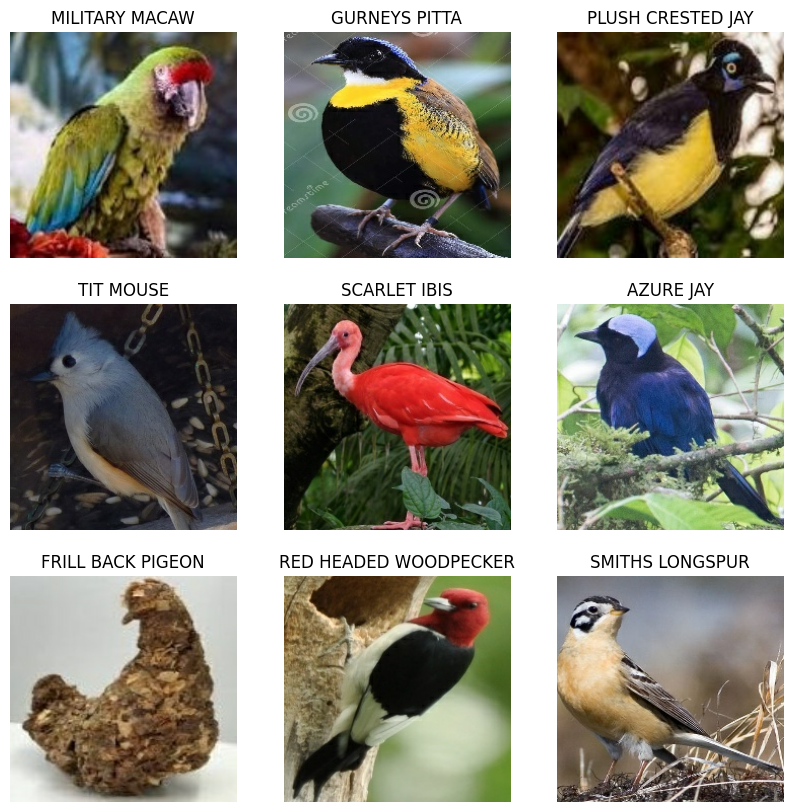

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [9]:
for x, y in train_ds.take(1):
  print(x.shape, y)

(16, 224, 224, 3) tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(16, 525), dtype=float32)


Finalmente cargamos nuestro dataset de entrenamiento:

In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                    directory= test_dir,
                    labels = 'inferred',
                    label_mode = 'categorical',
                    seed=random_seed,
                    shuffle=False,
                    batch_size=batch_size,
                    image_size = (224,224)
)

Found 2625 files belonging to 525 classes.


## Evaluando el modelo preentrenado de Kaggle

In [11]:
model = keras.models.load_model('./EfficientNetB0-525-(224 X 224)- 98.97.h5', custom_objects={'F1_score':'F1_score'})

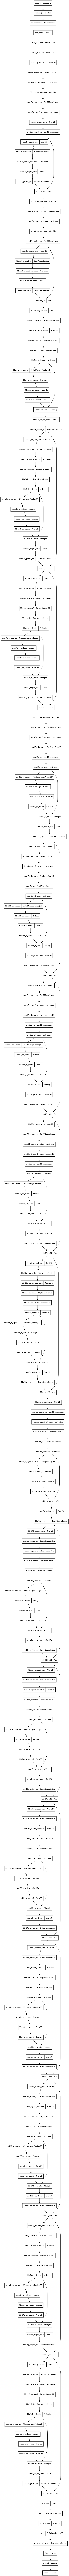

In [12]:
tf.keras.utils.plot_model(model)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]']   

Probamos el modelo con el dataset de prueba:

In [14]:
test_pred = model.predict(test_ds)

165/165 [==============================] - 6s 13ms/step


In [15]:
test_data = test_ds.unbatch()
test_labels = []
for i, (imagen, etiqueta) in enumerate(test_data):
  test_labels.append(np.argmax(etiqueta.numpy()))

In [16]:
pred_test = np.zeros(len(test_labels))

for id in range(len(test_labels)):
    pred_test[id] = np.argmax( test_pred[id] )

Finalmente, mostramos la exactitud (Accuracy) del modelo:

In [17]:
from sklearn.metrics import classification_report, accuracy_score

#print(classification_report(test_labels, pred_test))
print(f"Accuracy of the Model: {accuracy_score(test_labels, pred_test)*100:.2f}%")

Accuracy of the Model: 98.97%


## Armando nuestro propio modelo con Transfer Learning

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Cargando nuestro modelo preentrenado, tomando solo la parte convolucional:

In [19]:
IMG_SHAPE = IMG_SIZE + (3,)

modelo_base_EFB3 = tf.keras.applications.EfficientNetV2B3(
    input_shape = IMG_SHAPE, # [96, 128, 160, 192, 224] No acepta imagenes mas grandes
    include_top = False,
    weights     = 'imagenet',
    include_preprocessing = False
)

modelo_base_EFB3.trainable = False

52606240/52606240 [==============================] - 0s 0us/step


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.82793 to fit



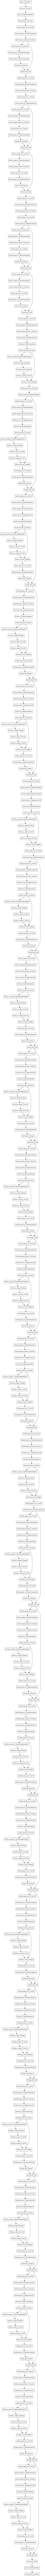

In [20]:
tf.keras.utils.plot_model(modelo_base_EFB3)

In [21]:
modelo_base_EFB3.summary()

Model: "efficientnetv2-b3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 40)         1080      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 40)         160       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 40)         0         ['stem_bn[0][0

In [22]:
nb_layers = len(modelo_base_EFB3.layers)
print(modelo_base_EFB3.layers[nb_layers - 2].name)
print(modelo_base_EFB3.layers[nb_layers - 1].name)

top_bn
top_activation


Aumentamos nuestros datos antes de generar el nuevo modelo

In [23]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2)
])

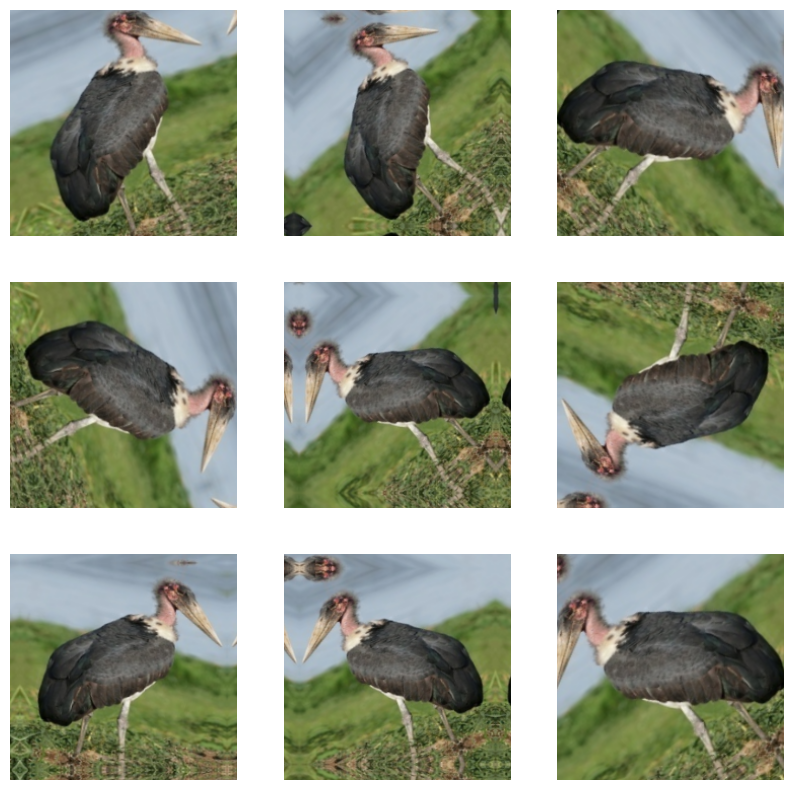

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Creamos nuestro nuevo modelo a partir del modelo base:

In [25]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x =  keras.layers.Rescaling(1./255)(x)
# x = keras.layers.LayerNormalization()(x)
x = modelo_base_EFB3(x, training=False)

max_pooling = keras.layers.GlobalMaxPooling2D(name = 'max_pooling')(x)
batch_norm = BatchNormalization(name = 'batch_norm')(max_pooling)
dense_1 = Dense(1000, activation = 'relu', name = 'dense_1')(batch_norm)
#flatten             = Flatten()(x)
drop = Dropout(0.3)(dense_1)
outputs_EFB3 = Dense(525, activation='softmax', name = 'prediction' )(drop)

modelo_EFB3 = tf.keras.Model(inputs=inputs, outputs=outputs_EFB3)

In [26]:
modelo_EFB3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 max_pooling (GlobalMaxPool  (None, 1536)              0         
 ing2D)                                                          
                                                                 
 batch_norm (BatchNormaliza  (None, 1536)              6144  

In [27]:
base_learning_rate = 0.001
modelo_EFB3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss      = tf.keras.losses.CategoricalCrossentropy(),
    metrics   = ['accuracy']
)

In [28]:
%time  historial = modelo_EFB3.fit(train_ds, validation_data = val_ds, epochs=30,  verbose=1, callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)])

Epoch 1/30
4232/4232 [==============================] - 136s 29ms/step - loss: 3.3986 - accuracy: 0.3269 - val_loss: 1.5396 - val_accuracy: 0.6257
Epoch 2/30
4232/4232 [==============================] - 115s 27ms/step - loss: 2.4188 - accuracy: 0.4683 - val_loss: 1.0979 - val_accuracy: 0.7207
Epoch 3/30
4232/4232 [==============================] - 116s 27ms/step - loss: 2.1081 - accuracy: 0.5242 - val_loss: 1.0643 - val_accuracy: 0.7264
Epoch 4/30
4232/4232 [==============================] - 115s 27ms/step - loss: 1.8794 - accuracy: 0.5644 - val_loss: 0.8572 - val_accuracy: 0.7750
Epoch 5/30
4232/4232 [==============================] - 116s 27ms/step - loss: 1.7022 - accuracy: 0.5935 - val_loss: 0.8153 - val_accuracy: 0.7863
Epoch 6/30
4232/4232 [==============================] - 116s 27ms/step - loss: 1.5689 - accuracy: 0.6198 - val_loss: 0.6687 - val_accuracy: 0.8215
Epoch 7/30
4232/4232 [==============================] - 117s 28ms/step - loss: 1.4773 - accuracy: 0.6352 - val_loss: 0

In [29]:
def plot_hist_acc(hist):
    plt.plot(hist.history["accuracy"],'r')

    plt.plot(hist.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Categorical Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    #plt.ylim((0,1.1))
    plt.grid()
    plt.show()

def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])

    plt.plot(hist.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss (Categorical Crossentropy)")
    plt.xlabel("Epoch")
    plt.legend(["loss", "val_loss"], loc="upper left")
    #plt.ylim((-0.01,np.max(hist.history["loss"])+0.01))
    plt.grid()
    plt.show()

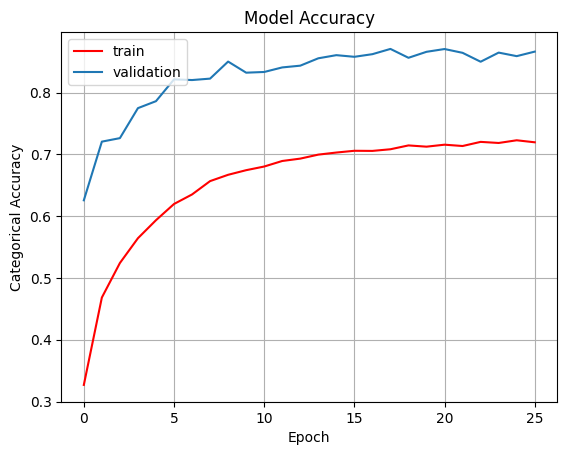

In [30]:
plot_hist_acc(historial)

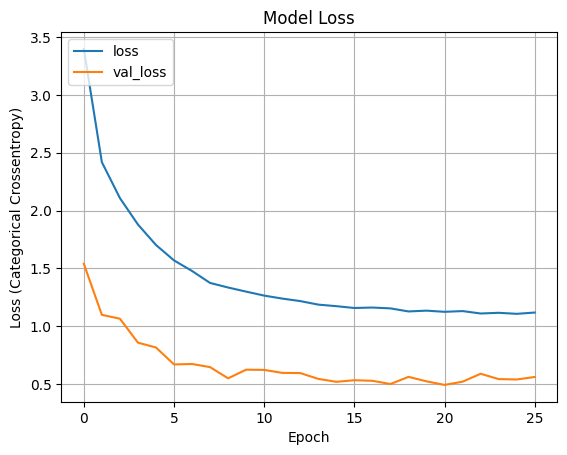

In [31]:
plot_hist_loss(historial)

Por ultimo, hacemos un fine tuning del modelo final, para tratar de mejorar aun mas la precision de este:

In [33]:
# Con esto hacemos que todos los parametros del modelo sean entrenables (anteriormente se habia seteado como training = False, para tener el modelo base en modo inferencia)
modelo_EFB3.trainable = True

# Compliamos para el fine-tuning
modelo_EFB3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=["accuracy"])

# Entrenamos para el fine-tuning

%time history_fine_tuning = modelo_EFB3.fit(train_ds, validation_data = val_ds, epochs=2,  verbose=1)

Epoch 1/2
4232/4232 [==============================] - 488s 101ms/step - loss: 0.5723 - accuracy: 0.8524 - val_loss: 0.3012 - val_accuracy: 0.9322
Epoch 2/2
4232/4232 [==============================] - 423s 100ms/step - loss: 0.4083 - accuracy: 0.8893 - val_loss: 0.2622 - val_accuracy: 0.9413
CPU times: user 15min 53s, sys: 26.4 s, total: 16min 20s
Wall time: 15min 10s


Afinamos por otras dos epocas mas para tratar de alcanzar una precision aun mayor

In [34]:
%time history_fine_tuning = modelo_EFB3.fit(train_ds, validation_data = val_ds, epochs=2,  verbose=1)

Epoch 1/2
4232/4232 [==============================] - 422s 100ms/step - loss: 0.3481 - accuracy: 0.9036 - val_loss: 0.2355 - val_accuracy: 0.9468
Epoch 2/2
4232/4232 [==============================] - 423s 100ms/step - loss: 0.3069 - accuracy: 0.9146 - val_loss: 0.2212 - val_accuracy: 0.9477
CPU times: user 14min 50s, sys: 24.9 s, total: 15min 15s
Wall time: 14min 4s


Finalmente, probamos nuestro modelo con el dataset de prueba `test_ds` para obtener la precisión de éste:

In [35]:
test_pred_B3 = modelo_EFB3.predict(test_ds)

165/165 [==============================] - 6s 21ms/step


In [36]:
pred_test_B3 = np.zeros(len(test_labels))

for id in range(len(test_labels)):
    pred_test_B3[id] = np.argmax( test_pred_B3[id] )

Verificamos el accuracy de nuestro propio modelo, en este caso obtuvimos un accuracy del 94.4%:

In [38]:
from sklearn.metrics import classification_report, accuracy_score

#print(classification_report(test_labels, pred_test))
print(f"Accuracy of the Model: {accuracy_score(test_labels, pred_test_B3)*100:.2f}%")

Accuracy of the Model: 94.29%


## Probando el modelo con el set de validación:

In [39]:
from tensorflow.keras.utils import load_img, img_to_array
import pandas as pd

In [40]:
def truncate_float(float_number, decimal_places):
    multiplier = 10 ** decimal_places
    return int(float_number * multiplier) / multiplier

In [41]:
valid_df = pd.read_csv('./birds.csv')

In [42]:
valid_df = valid_df[valid_df['data set'] == 'test']

In [43]:
valid_df.drop(['class id', 'data set'], axis = 1, inplace = True)

In [44]:
valid_df['filepaths'] = valid_df['filepaths'].apply(lambda x: './dataset/' + x)

In [45]:
valid_df.head()

filepaths           labels  \
84635  ./dataset/test/ABBOTTS BABBLER/1.jpg  ABBOTTS BABBLER   
84636  ./dataset/test/ABBOTTS BABBLER/2.jpg  ABBOTTS BABBLER   
84637  ./dataset/test/ABBOTTS BABBLER/3.jpg  ABBOTTS BABBLER   
84638  ./dataset/test/ABBOTTS BABBLER/4.jpg  ABBOTTS BABBLER   
84639  ./dataset/test/ABBOTTS BABBLER/5.jpg  ABBOTTS BABBLER   

            scientific name  
84635  MALACOCINCLA ABBOTTI  
84636  MALACOCINCLA ABBOTTI  
84637  MALACOCINCLA ABBOTTI  
84638  MALACOCINCLA ABBOTTI  
84639  MALACOCINCLA ABBOTTI

In [46]:
import pandas as pd

In [47]:
no_dupes_df = valid_df[['labels','scientific name']].drop_duplicates()

In [48]:
no_dupes_df.sample(10)

labels           scientific name
86805  SCARLET FACED LIOCICHLA         LIOCICHLA RIPPONI
87000             TREE SWALLOW       TACHYCINETA BICOLOR
86875            SPLENDID WREN         MALURUS SPLENDENS
85360      CINNAMON FLYCATCHER   PYRRHOMYIAS CINNAMOMEUS
85280             CAPUCHINBIRD  PERISSOCEPHALUS TRICOLOR
86440   ORANGE BREASTED TROGON        HARPACTES ORESKIOS
86445   ORANGE BRESTED BUNTING    PASSERINA LECLANCHERII
85865            GRAY KINGBIRD     TYRANNUS DOMINICENSIS
86945              SURF SCOTER   MELANITTA PERSPICILLATA
85285        CARMINE BEE-EATER         MEROPS NUBICOIDES

In [49]:
species_dict_2 = pd.Series(no_dupes_df['scientific name'].values,index=no_dupes_df['labels']).to_dict()

In [50]:
species_dict_2

{'ABBOTTS BABBLER': 'MALACOCINCLA ABBOTTI',
 'ABBOTTS BOOBY': 'PAPASULA ABBOTTI',
 'ABYSSINIAN GROUND HORNBILL': 'BUCORVUS ABYSSINICUS',
 'AFRICAN CROWNED CRANE': 'BALEARICA REGULORUM',
 'AFRICAN EMERALD CUCKOO': 'CHRYSOCOCCYX CUPREUS',
 'AFRICAN FIREFINCH': 'LAGONOSTICTA RUBRICATA',
 'AFRICAN OYSTER CATCHER': 'HAEMATOPUS MOQUINI',
 'AFRICAN PIED HORNBILL': 'TOCKUS FASCIATUS',
 'AFRICAN PYGMY GOOSE': 'NETTAPUS AURITUS',
 'ALBATROSS': 'DIOMEDEIDAE',
 'ALBERTS TOWHEE': 'PIPILO ABERTI',
 'ALEXANDRINE PARAKEET': 'PSITTACULA EUPATRIA',
 'ALPINE CHOUGH': 'PYRRHOCORAX GRACULUS',
 'ALTAMIRA YELLOWTHROAT': 'GEOTHLYPIS FLAVOVELATA',
 'AMERICAN AVOCET': 'PSITTACULA EUPATRIA',
 'AMERICAN BITTERN': 'BOTAURUS LENTIGINOSUS',
 'AMERICAN COOT': 'FULICA AMERICANA',
 'AMERICAN FLAMINGO': 'PHOENICOPTERUS RUBER',
 'AMERICAN GOLDFINCH': 'SPINUS TRISTIS',
 'AMERICAN KESTREL': 'FALCO SPARVERIUS',
 'AMERICAN PIPIT': 'ANTHUS RUBESCENS',
 'AMERICAN REDSTART': 'SETOPHAGA RUTICILLA',
 'AMERICAN ROBIN': 'TURDUS MIG

In [51]:
import json
with open('birds.json', 'w') as fp:
    json.dump(species_dict_2, fp)

In [52]:
# Combinaciones no son correctas
#species_dict = {k: v for k,v in zip(valid_df['labels'].unique(),valid_df['scientific name'].unique())}

In [53]:
# species_dict

1/1 [==============================] - 0s 33ms/step


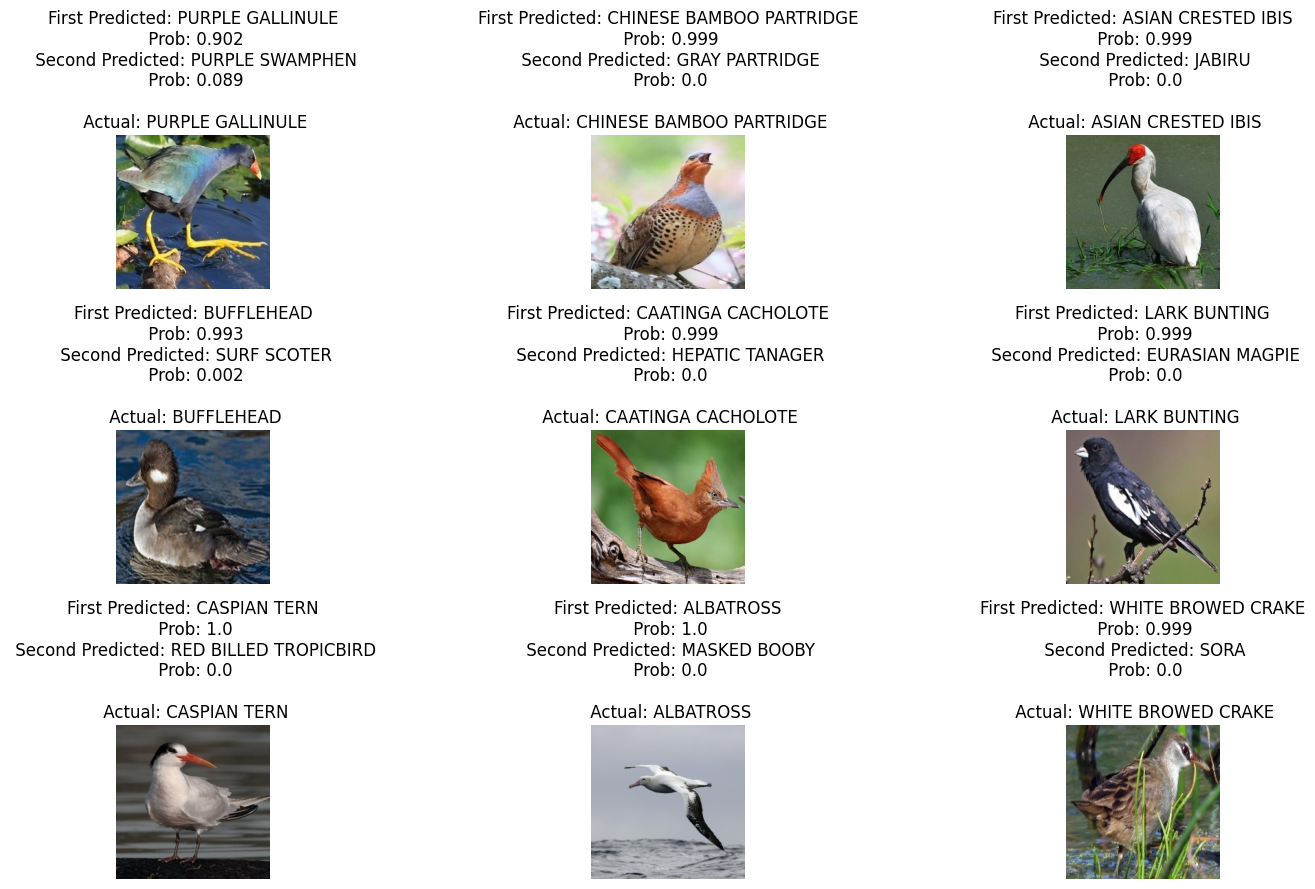

In [54]:
fig, axes = plt.subplots(3, 3, figsize= (16,9))
for ax in axes.reshape(-1):
    filename, label = valid_df.sample(1).loc[:,['filepaths', 'labels']].values[0]
    img = load_img(filename, target_size=(224,224))
    imgconv = img_to_array(img)
    img_array = np.expand_dims(imgconv,axis=0)
    prediction = modelo_EFB3.predict(img_array)
    pred_class = np.argmax(prediction)
    pred_class_2 = np.argpartition(prediction[0,:], -2)[-2]
    pred_proba = np.max(prediction)
    pred_proba_2 = np.partition(prediction[0,:], -2)[-2]
    ax.imshow(img)
    ax.set_title(f'First Predicted: {class_names[pred_class]}\n Prob: {truncate_float(pred_proba,3)}\n Second Predicted: {class_names[pred_class_2]}\n Prob: {truncate_float(pred_proba_2,3)}\n\n Actual: {label}')
    ax.axis("off")

fig.tight_layout()
fig.show()

In [55]:
modelo_EFB3.save('./modelo_EFB3_525_rescale_9429.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
!pip freeze | grep tensorflow

tensorflow @ https://storage.googleapis.com/colab-tf-builds-public-09h6ksrfwbb9g9xv/tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl#sha256=a2ec79931350b378c1ef300ca836b52a55751acb71a433582508a07f0de57c42
tensorflow-datasets==4.9.4
tensorflow-estimator==2.15.0
tensorflow-gcs-config==2.15.0
tensorflow-hub==0.16.1
tensorflow-io-gcs-filesystem==0.37.0
tensorflow-metadata==1.15.0
tensorflow-probability==0.23.0
